# 1. Preparación de datos

## Importar librerías

In [15]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

## Conexiones

In [3]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargar datos

In [4]:
# Cargar bases de datos procesadas
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

In [5]:
# Ver las formas (número de imágenes, alto, ancho, canales, etc.)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5712, 198, 150, 3)
y_train shape: (5712, 1)
x_test shape: (1311, 198, 150, 3)
y_test shape: (1311, 1)


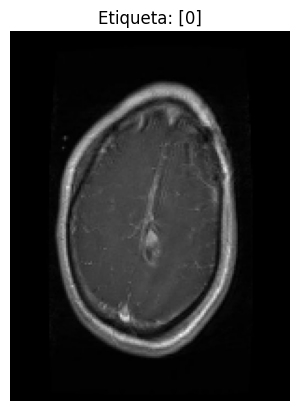

In [6]:
# Mostrar la imagen
plt.imshow(x_train[999])
plt.title(f"Etiqueta: {y_train[999]}")
plt.axis('off')
plt.show()

## Preparación de datos

In [7]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [9]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 198, 150, 3)
Shape x_test: (1311, 198, 150, 3)


In [10]:
# Convertir a 1D
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)

x_train2.shape
x_test2.shape

x_train2[1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<ipython-input-11-741af3695b3b>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Etiqueta: {int(y_train[1])}")


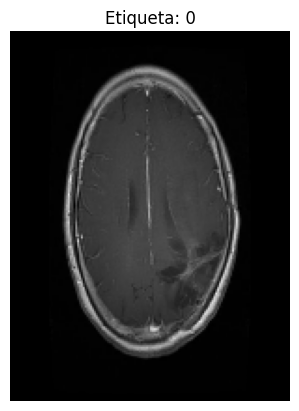

In [11]:
# Reconstruir la forma original (198 alto, 150 ancho, 3 canales)
img = x_train2[1].reshape((198, 150, 3))

# Mostrar la imagen
plt.imshow(img)
plt.title(f"Etiqueta: {int(y_train[1])}")
plt.axis('off')
plt.show()

#2. Preprocesamiento  para modelos tradicionales

## Regresión Logística

In [19]:
# Asegurar que las etiquetas tengan la forma correcta
y_train = y_train.ravel()
y_test = y_test.ravel()

# Entrenar el modelo
#lr = LogisticRegression(max_iter=100, solver='saga') # se queda corriendo :(
lr=LogisticRegression(max_iter=150)
lr.fit(x_train2, y_train)

# Predicciones en entrenamiento
pred_train_lr = lr.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_lr, zero_division=0))

# AUC en entrenamiento
probs_train_lr = lr.predict_proba(x_train2)
print("AUC train:", metrics.roc_auc_score(y_train, probs_train_lr, multi_class='ovr', average='macro'))

# Predicciones en test
pred_test_lr = lr.predict(x_test2)
print("Test:")
print(metrics.classification_report(y_test, pred_test_lr, zero_division=0))

# AUC en test
probs_test_lr = lr.predict_proba(x_test2)
print("AUC test:", metrics.roc_auc_score(y_test, probs_test_lr, multi_class='ovr', average='macro'))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

AUC train: 1.0
Test:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       300
           1       0.76      0.79      0.77       306
           2       0.93      0.96      0.94       300
           3       0.97      0.99      0.98       405

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311

AUC test: 0.9682258881071657


## Random Forest

In [13]:
# Entrenar el modelo
rf = RandomForestClassifier()
rf.fit(x_train2, y_train.ravel())

# Entrenamos el modelo Random Forest utilizando los datos de entrenamiento.
# Se usa .ravel() para convertir y_train de un arreglo de 2 dimensiones (n,1) a 1 dimensión (n,)
# ya que RandomForestClassifier espera un vector unidimensional como etiquetas.


# Predicciones para train
pred_train = rf.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))

# Probabilidades para train (todas las clases)
pred_train_proba = rf.predict_proba(x_train2)
roc_auc_train = metrics.roc_auc_score(y_train, pred_train_proba, multi_class='ovr')
print("ROC AUC train:", roc_auc_train)

# Predicciones para test
pred_test = rf.predict(x_test2)
print(metrics.classification_report(y_test, pred_test))

# Probabilidades para test (todas las clases)
pred_test_proba = rf.predict_proba(x_test2)
roc_auc_test = metrics.roc_auc_score(y_test, pred_test_proba, multi_class='ovr')
print("ROC AUC test:", roc_auc_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       300
           1       0.84      0.92      0.88       306
           2       0.94      0.98      0.96       300
           3       0.98      1.00      0.99       405

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.93      1311

ROC AUC test: 0.992057023284346


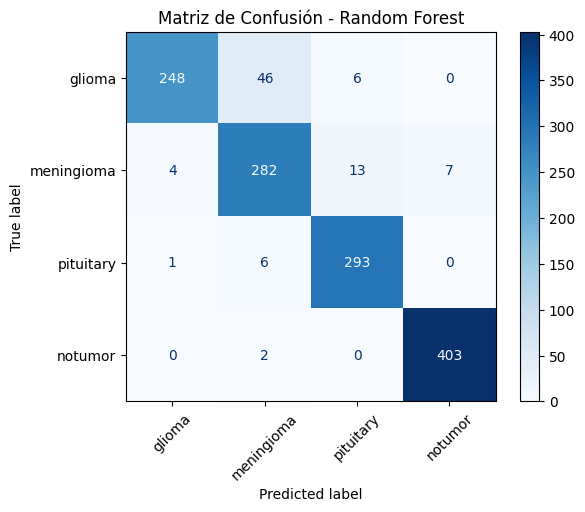

In [16]:
# Obtener las predicciones sobre el conjunto de prueba
pred_test = rf.predict(x_test2)

# Definir las etiquetas de las clases
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión
cm = confusion_matrix(y_test, pred_test, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

## K Nearest Neighbor

In [14]:
# Entrenar el modelo
knc = KNeighborsClassifier()
knc.fit(x_train2, y_train.ravel())

# Predicciones para entrenamiento
pred_train_knc = knc.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_knc))

# Probabilidades para train (todas las clases)
proba_train_knc = knc.predict_proba(x_train2)
roc_auc_train_knc = metrics.roc_auc_score(y_train, proba_train_knc, multi_class='ovr')
print("ROC AUC train:", roc_auc_train_knc)

# Predicciones para test
pred_test_knc = knc.predict(x_test2)
print("\nTest:")
print(metrics.classification_report(y_test, pred_test_knc))

# Probabilidades para test (todas las clases)
proba_test_knc = knc.predict_proba(x_test2)
roc_auc_test_knc = metrics.roc_auc_score(y_test, proba_test_knc, multi_class='ovr')
print("ROC AUC test:", roc_auc_test_knc)

Entrenamiento:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1321
           1       0.95      0.81      0.87      1339
           2       0.94      0.98      0.96      1457
           3       0.95      0.95      0.95      1595

    accuracy                           0.93      5712
   macro avg       0.93      0.92      0.92      5712
weighted avg       0.93      0.93      0.93      5712

ROC AUC train: 0.994637259822943

Test:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       300
           1       0.90      0.53      0.67       306
           2       0.89      0.99      0.93       300
           3       0.88      0.94      0.91       405

    accuracy                           0.85      1311
   macro avg       0.86      0.85      0.84      1311
weighted avg       0.86      0.85      0.84      1311

ROC AUC test: 0.9794718089150051


## Decision Tree

In [ ]:
# Entrenar el modelo
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train2, y_train)

# Predicciones para entrenamiento
pred_train_dt = clf_dt.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_dt))

# Probabilidades para entrenamiento (todas las clases)
proba_train_dt = clf_dt.predict_proba(x_train2)
roc_auc_train_dt = metrics.roc_auc_score(y_train, proba_train_dt, multi_class='ovr')
print("ROC AUC train:", roc_auc_train_dt)

# Predicciones para test
pred_test_dt = clf_dt.predict(x_test2)
print("\nTest:")
print(metrics.classification_report(y_test, pred_test_dt))

# Probabilidades para test (todas las clases)
proba_test_dt = clf_dt.predict_proba(x_test2)
roc_auc_test_dt = metrics.roc_auc_score(y_test, proba_test_dt, multi_class='ovr')
print("ROC AUC test:", roc_auc_test_dt)

Entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0

Test:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       300
           1       0.73      0.79      0.76       306
           2       0.88      0.89      0.89       300
           3       0.97      0.97      0.97       405

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.86      1311
weighted avg       0.87      0.86      0.86      1311

ROC AUC test: 0.9049835737606595


# Redes Neuronales NN

In [ ]:
 # Crear modelo secuencial (capas apiladas)
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]), #Aplanar entrada
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa con 128 neuronas y ReLU
    tf.keras.layers.Dense(64, activation='relu'), # Capa densa con 64 neuronas y ReLU
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida (1 neurona), activación sigmoide para clasificación binaria
])

# Optimizador y funcion de perdida para el modelo
fc_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Recall', 'Precision'] #Metricas a evaluar
)

# entrenar el modelo con validacion
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - AUC: 0.5093 - Precision: 0.7724 - Recall: 0.9907 - accuracy: 0.2356 - loss: -2672.2275 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -27820.8574
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - AUC: 0.5000 - Precision: 0.7691 - Recall: 1.0000 - accuracy: 0.2317 - loss: -54980.0273 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -195314.8594
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - AUC: 0.5000 - Precision: 0.7796 - Recall: 1.0000 - accuracy: 0.2369 - loss: -288220.2812 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -670906.0000
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - AUC: 0.5000 - Precision: 0.7618 - Recall: 1.0000 - accuracy: 0.2390 - loss: -833145.6250 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_los

In [21]:
# Etiquetas como enteros (0, 1, 2, ...)
y_train = np.array(y_train).astype('int32')
y_test = np.array(y_test).astype('int32')

# Cantidad de clases
num_classes = len(np.unique(y_train))

# Pesos de clase
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

# Modelo para multiclase
fc_model = Sequential()
fc_model.add(Flatten(input_shape=x_train.shape[1:]))
fc_model.add(Dense(128, activation='relu'))
fc_model.add(Dense(64, activation='relu'))
fc_model.add(Dense(num_classes, activation='softmax'))  # salida multiclase

# Compilar modelo
fc_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',  # <- multiclase
                 metrics=['accuracy'])

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
fc_model.fit(x_train, y_train,
             batch_size=100,
             epochs=10,
             validation_data=(x_test, y_test),
             callbacks=[checkpoint],
             class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.4188 - loss: 4.8875
Epoch 1: val_accuracy improved from -inf to 0.67582, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - accuracy: 0.4208 - loss: 4.8489 - val_accuracy: 0.6758 - val_loss: 0.9452
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7330 - loss: 0.7091
Epoch 2: val_accuracy improved from 0.67582 to 0.77574, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.7335 - loss: 0.7080 - val_accuracy: 0.7757 - val_loss: 0.5943
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8038 - loss: 0.5468
Epoch 3: val_accuracy did not improve from 0.77574
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 469ms/step - accuracy: 0.8037 - loss: 0.5469 - val_accuracy: 0.7162 - val_loss: 0.7501
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8023 - loss: 0.5150
Epoch 4: val_accuracy did not improve from 0.77574
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.8024 - loss: 0.5150 - val_accuracy: 0.6995 - val_loss: 0.6944
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8219 - loss: 0.5140
Epoch 5: val_accuracy improved from 0.77574 to 0.80549, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.8222 - loss: 0.5131 - val_accuracy: 0.8055 - val_loss: 0.5164
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8757 - loss: 0.3468
Epoch 6: val_accuracy improved from 0.80549 to 0.81998, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 361ms/step - accuracy: 0.8757 - loss: 0.3467 - val_accuracy: 0.8200 - val_loss: 0.4565
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9056 - loss: 0.2738
Epoch 7: val_accuracy did not improve from 0.81998
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.9057 - loss: 0.2739 - val_accuracy: 0.7849 - val_loss: 0.5338
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8955 - loss: 0.3034
Epoch 8: val_accuracy improved from 0.81998 to 0.85355, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.8956 - loss: 0.3033 - val_accuracy: 0.8535 - val_loss: 0.3950
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9066 - loss: 0.2794
Epoch 9: val_accuracy did not improve from 0.85355
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.9066 - loss: 0.2794 - val_accuracy: 0.7857 - val_loss: 0.6613
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9153 - loss: 0.2559
Epoch 10: val_accuracy did not improve from 0.85355
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.9153 - loss: 0.2559 - val_accuracy: 0.7407 - val_loss: 0.9210
